In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

# Load Data

path = os.path.join(os.getcwd(),'..')

df_stocks = pd.read_csv(os.path.join(path, 'data-reader/data/sample-stocks.csv'))
_d1 = df_stocks.set_index(['Date', 'Symbol'])
_d2 = _d1.groupby(level='Symbol').pct_change()*100
_d3 = _d2.rename(lambda name: name+'_pct', axis=1)

df_stocks2 = pd.concat([_d1,_d3], axis=1)
df_stocks2[['Date','Symbol']] = df_stocks2.index.to_frame()

df_ff5 = pd.read_csv(os.path.join(path, 'data-reader/data/sample-ff5.csv'))

df = pd.merge_ordered(df_stocks2, df_ff5, on='Date')
df = df.dropna()

D:\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:241: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  result = _merger(left, right)


In [2]:
# CAPM-based analysis

df['Ri-Rf'] = df['Adj Close_pct'] - df['RF']
df['Rm-Rf'] = df['Mkt-RF']

show_sets = []
for g,df_g in df.groupby('Symbol'):
    y = df_g['Ri-Rf']
    X = sm.add_constant(df_g['Rm-Rf'])
    model = sm.OLS(y, X)
    result = model.fit()
    
    show_set = {'Symbol':g,
                'alpha':result.params[0],
                'alpha_std':result.HC0_se[0],
                'beta':result.params[1],
                'beta_std':result.HC0_se[1],
                'R2':result.rsquared}
    show_sets.append(show_set)
results_capm = pd.DataFrame(show_sets,
                            columns=['Symbol','alpha','alpha_std',
                                     'beta','beta_std','R2'])
results_capm.T

,0,1,2,3,4,5,6,7,8
Symbol,AAPL,AXP,GE,GS,INTC,PG,WMT,XOM,^GSPC
alpha,0.118216,0.0126927,-0.0273112,0.0101765,0.013656,0.0176141,0.0235563,0.0109863,-0.00843402
alpha_std,0.0323369,0.0213664,0.0187886,0.023098,0.0248859,0.0174572,0.0189822,0.0167767,0.00190167
beta,1.15143,1.36887,1.11958,1.40173,1.28735,0.486714,0.680634,0.767336,0.986512
beta_std,0.0340366,0.0296615,0.0320855,0.0433354,0.0280535,0.0231115,0.0217957,0.0269358,0.00292591
R2,0.263331,0.532669,0.495097,0.518929,0.428293,0.17948,0.264357,0.367922,0.986861


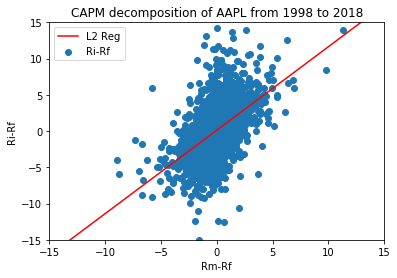

In [3]:
# Visualization of CAPM model
_r = results_capm[results_capm['Symbol']=='AAPL']
xarray = np.linspace(-15, 15)
yarray = _r.alpha[0] + _r.beta[0]*xarray
plt.figure()
plt.title('CAPM decomposition of AAPL from 1998 to 2018')
plt.scatter(df[df['Symbol']=='AAPL']['Rm-Rf'],
            df[df['Symbol']=='AAPL']['Ri-Rf'])
plt.plot(xarray, yarray, color='red', label='L2 Reg')
plt.xlabel('Rm-Rf')
plt.ylabel('Ri-Rf')
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.legend()
plt.show()

In [4]:
# TODO: use LAD regression via specified ML models

In [5]:
# FF5-based analysis

params = ['SMB','HML','RMW','CMA']
show_sets = []
for g,df_g in df.groupby('Symbol'):
    y = df_g['Ri-Rf']
    X = sm.add_constant(df_g[['Rm-Rf']+params])
    model = sm.OLS(y, X)
    result = model.fit()
    
    show_set = {'Symbol':g,
                'alpha':result.params[0],
                'alpha_std':result.HC0_se[0],
                'beta':result.params[1],
                'beta_std':result.HC0_se[1],
                'R2':result.rsquared}
    for param in params:
        show_set[param] = result.params[param]
        show_set['%s_std'%param] = result.HC0_se[param]
    show_sets.append(show_set)

results_ff5 = pd.DataFrame(show_sets,
                           columns=['Symbol','alpha','alpha_std',
                                    'beta','beta_std',
                                    'SMB','SMB_std',
                                    'HML','HML_std',
                                    'RMW','RMW_std',
                                    'CMA','CMA_std','R2'])
results_ff5.T

,0,1,2,3,4,5,6,7,8
Symbol,AAPL,AXP,GE,GS,INTC,PG,WMT,XOM,^GSPC
alpha,0.138683,0.0118178,-0.0287745,0.0303208,0.0290108,-0.001842,0.0137605,-0.00966091,-0.0103422
alpha_std,0.0312148,0.020201,0.0184285,0.0220101,0.0242497,0.0163938,0.0181065,0.0155035,0.00100433
beta,0.991539,1.3748,1.15012,1.2267,1.20489,0.69611,0.822136,0.970164,1.01677
beta_std,0.0353567,0.0296478,0.0397049,0.046417,0.0284993,0.0234169,0.0229289,0.0260728,0.00154457
SMB,-0.0457502,-0.333688,-0.327196,-0.276396,-0.292709,-0.29151,-0.375902,-0.187108,-0.141224
SMB_std,0.0677231,0.0461813,0.056382,0.0712962,0.0527251,0.0346152,0.0405971,0.0395745,0.00311743
HML,-0.338234,0.753928,0.331989,0.815631,-0.494408,-0.0964349,-0.28638,0.02376,0.0329531
HML_std,0.0643299,0.0673621,0.0663987,0.101142,0.0550873,0.0354665,0.0476394,0.0397529,0.00282931
RMW,-0.227314,0.121143,0.0345687,-0.518078,-0.331164,0.707033,0.528974,0.623882,0.107177
